# Load libraries and files

In [1]:
!export PYTHONUSERBASE=/projappl/project_2012638/

import sys
!{sys.executable} -m pip install --user pymannkendall -q
!{sys.executable} -m pip install --user tensorflow -q
!{sys.executable} -m pip install --user pyod -q
!{sys.executable} -m pip install --user 'tensorflow[and-cuda]' -q 
# Verify the installation:

In [1]:
import pandas as pd 
import psutil
import json
import matplotlib.pyplot as plt
import preprocess_functions as f 
import time 
import stats_helper as helper
import numpy as np
from scipy.stats import zscore
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

PATH = 'realKnownCause/'
ERRORPATH = 'labels/combined_labels.json'
# load error data
with open(ERRORPATH, "r") as file:
    error_file = json.load(file)

file_names = f.get_all_files(PATH) # return all file paths
time_diffs, preprocessed_dfs = list(), list()
for file_name in file_names:
    time_diff, preprocessed_df = f.process_time_series(file_name, error_file) 
    time_diffs.append(time_diff)
    preprocessed_dfs.append(preprocessed_df)

def window_sizes_freq(time_diff):
    window_sizes = dict()
    window_sizes['daily'] = int(60*60*24 / time_diff)
    window_sizes['time_of_day'] = int(window_sizes['daily'] / 4)
    return window_sizes 

window_sizes = [window_sizes_freq(timediff) for timediff in time_diffs]

add_mul_def = [
    helper.add_or_mul(preprocessed_df, window_size) 
               for preprocessed_df, window_size in zip(preprocessed_dfs, window_sizes)
]
stats_df = pd.DataFrame({
    'file_name': file_names,
    'tod_window': [i[1] for i in add_mul_def],
    'daily_window': [i[0] for i in add_mul_def]
})

# TimeGAN

In [2]:
from timegan_v2_18 import timegan 
from metrics.discriminative_score import discriminative_score_metrics
from metrics.predictive_score import predictive_score_metrics

2025-03-19 15:07:19.346771: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 15:07:20.249389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742389641.214172 3361091 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742389641.963398 3361091 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 15:07:24.968834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
def generate_timegan(preprocessed_df, filename):

    df = preprocessed_df.copy()
    freq = window_sizes[-1]['daily']
    data = np.array(df['value']).reshape(-1, 1)
    time_series = [data[i:i + freq] for i in range(len(data) - freq)]
    ori_data = np.array(time_series)

    # load best model 

    name_json = filename.split('/')[-1].split('.')[0] + '.json'
    json_model_path = 'timeganlogs/best_timegan_model_stats_'
    with open(json_model_path + name_json, 'r') as file:
        params = json.load(file)['best_params']
        
    parameters = {
                "hidden_dim": params['hidden_dim'],
                "num_layer": params['num_layer'],
                "iterations": 10000,
                "batch_size": params['batch_size'],
                "module": params['module']
            }
    
    generated_data = timegan(ori_data, parameters)
    generated_values = np.array([seq[-1] for seq in generated_data]).flatten()
    df.loc[freq:, 'generated_values'] = generated_values
    df['generated_values'] = df['generated_values'].bfill() 
    df['residual'] = df['value'] - df['generated_values']

    return df 


In [6]:
results = list() 
for filename, preprocessed_df in zip(file_names, preprocessed_dfs):
    df = generate_timegan(preprocessed_df, filename)
    results.append(df)

I0000 00:00:1742389841.643596 3361091 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed


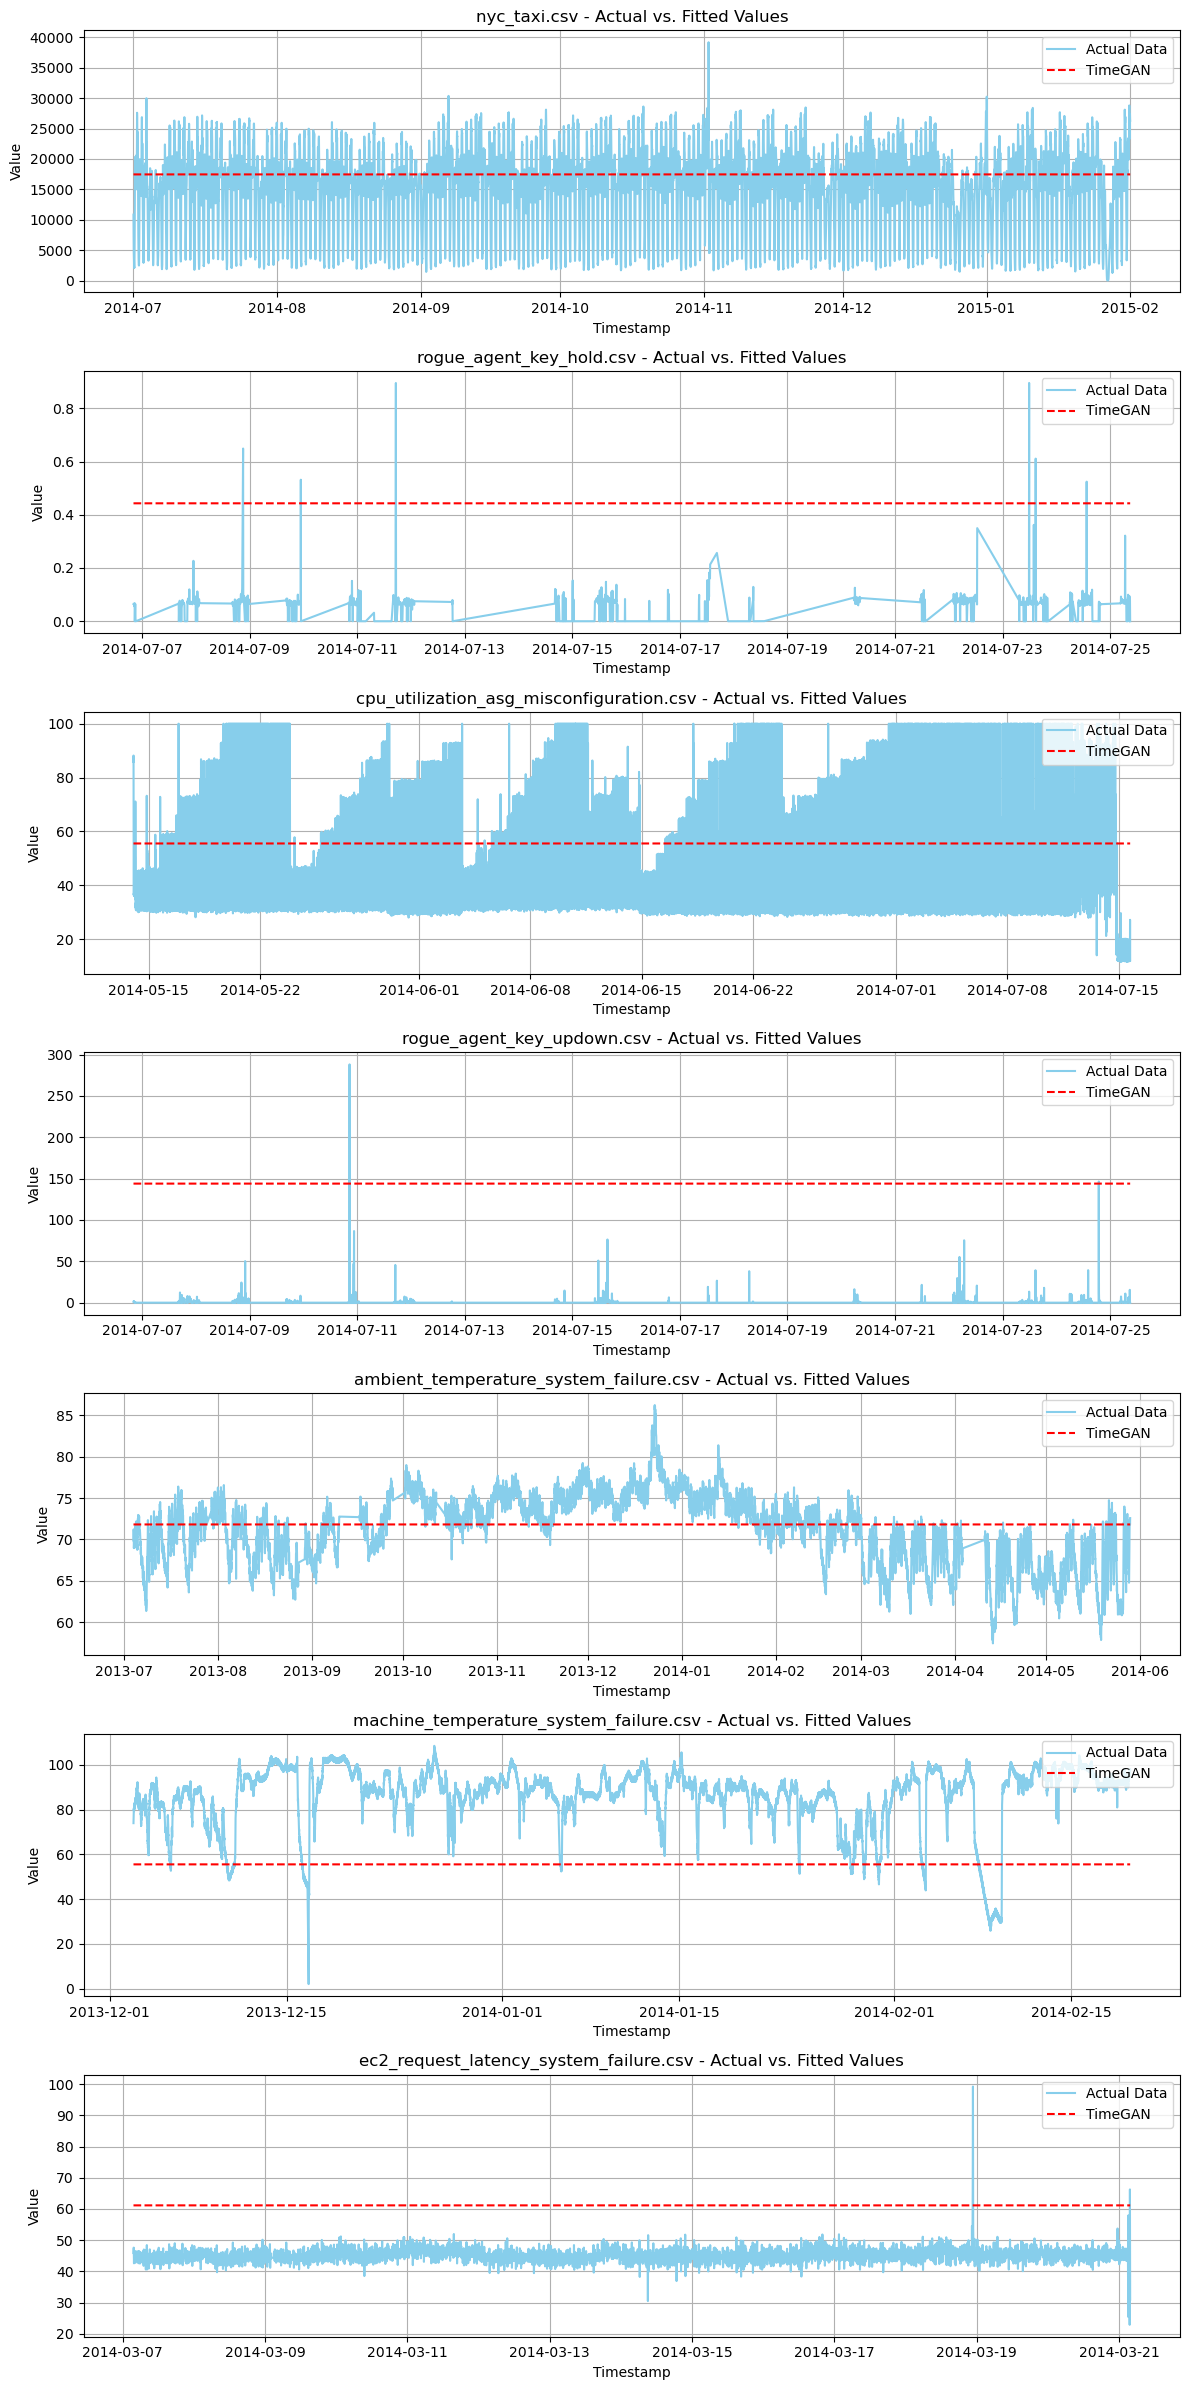

In [7]:
def plotting(df, col, fitted_col, title, ax, model):
    
    ax.plot(df['timestamp'], df[col], label="Actual Data", color='skyblue')

    # Plot fitted values (predictions from ARIMA)
    ax.plot(df['timestamp'], df[fitted_col], label=model, color='red', linestyle='dashed')

    # Formatting
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Value")
    ax.set_title(f"{title} - Actual vs. Fitted Values")
    ax.legend(loc='upper right')
    ax.grid(True)

fig, axes = plt.subplots(len(results), 1, figsize=(12, 24))  # Create a 2x1 grid of subplots
i = 0


for filename, result_df in zip(file_names, results):
    filename = filename.split('/')[1]
    plotting(result_df, 'value', 'generated_values', filename, axes[i], 'TimeGAN')
    i += 1
    
# Show plot
plt.tight_layout()
#plt.savefig('timegan_generated_allfiles.png')
plt.show()

# Plot residuals

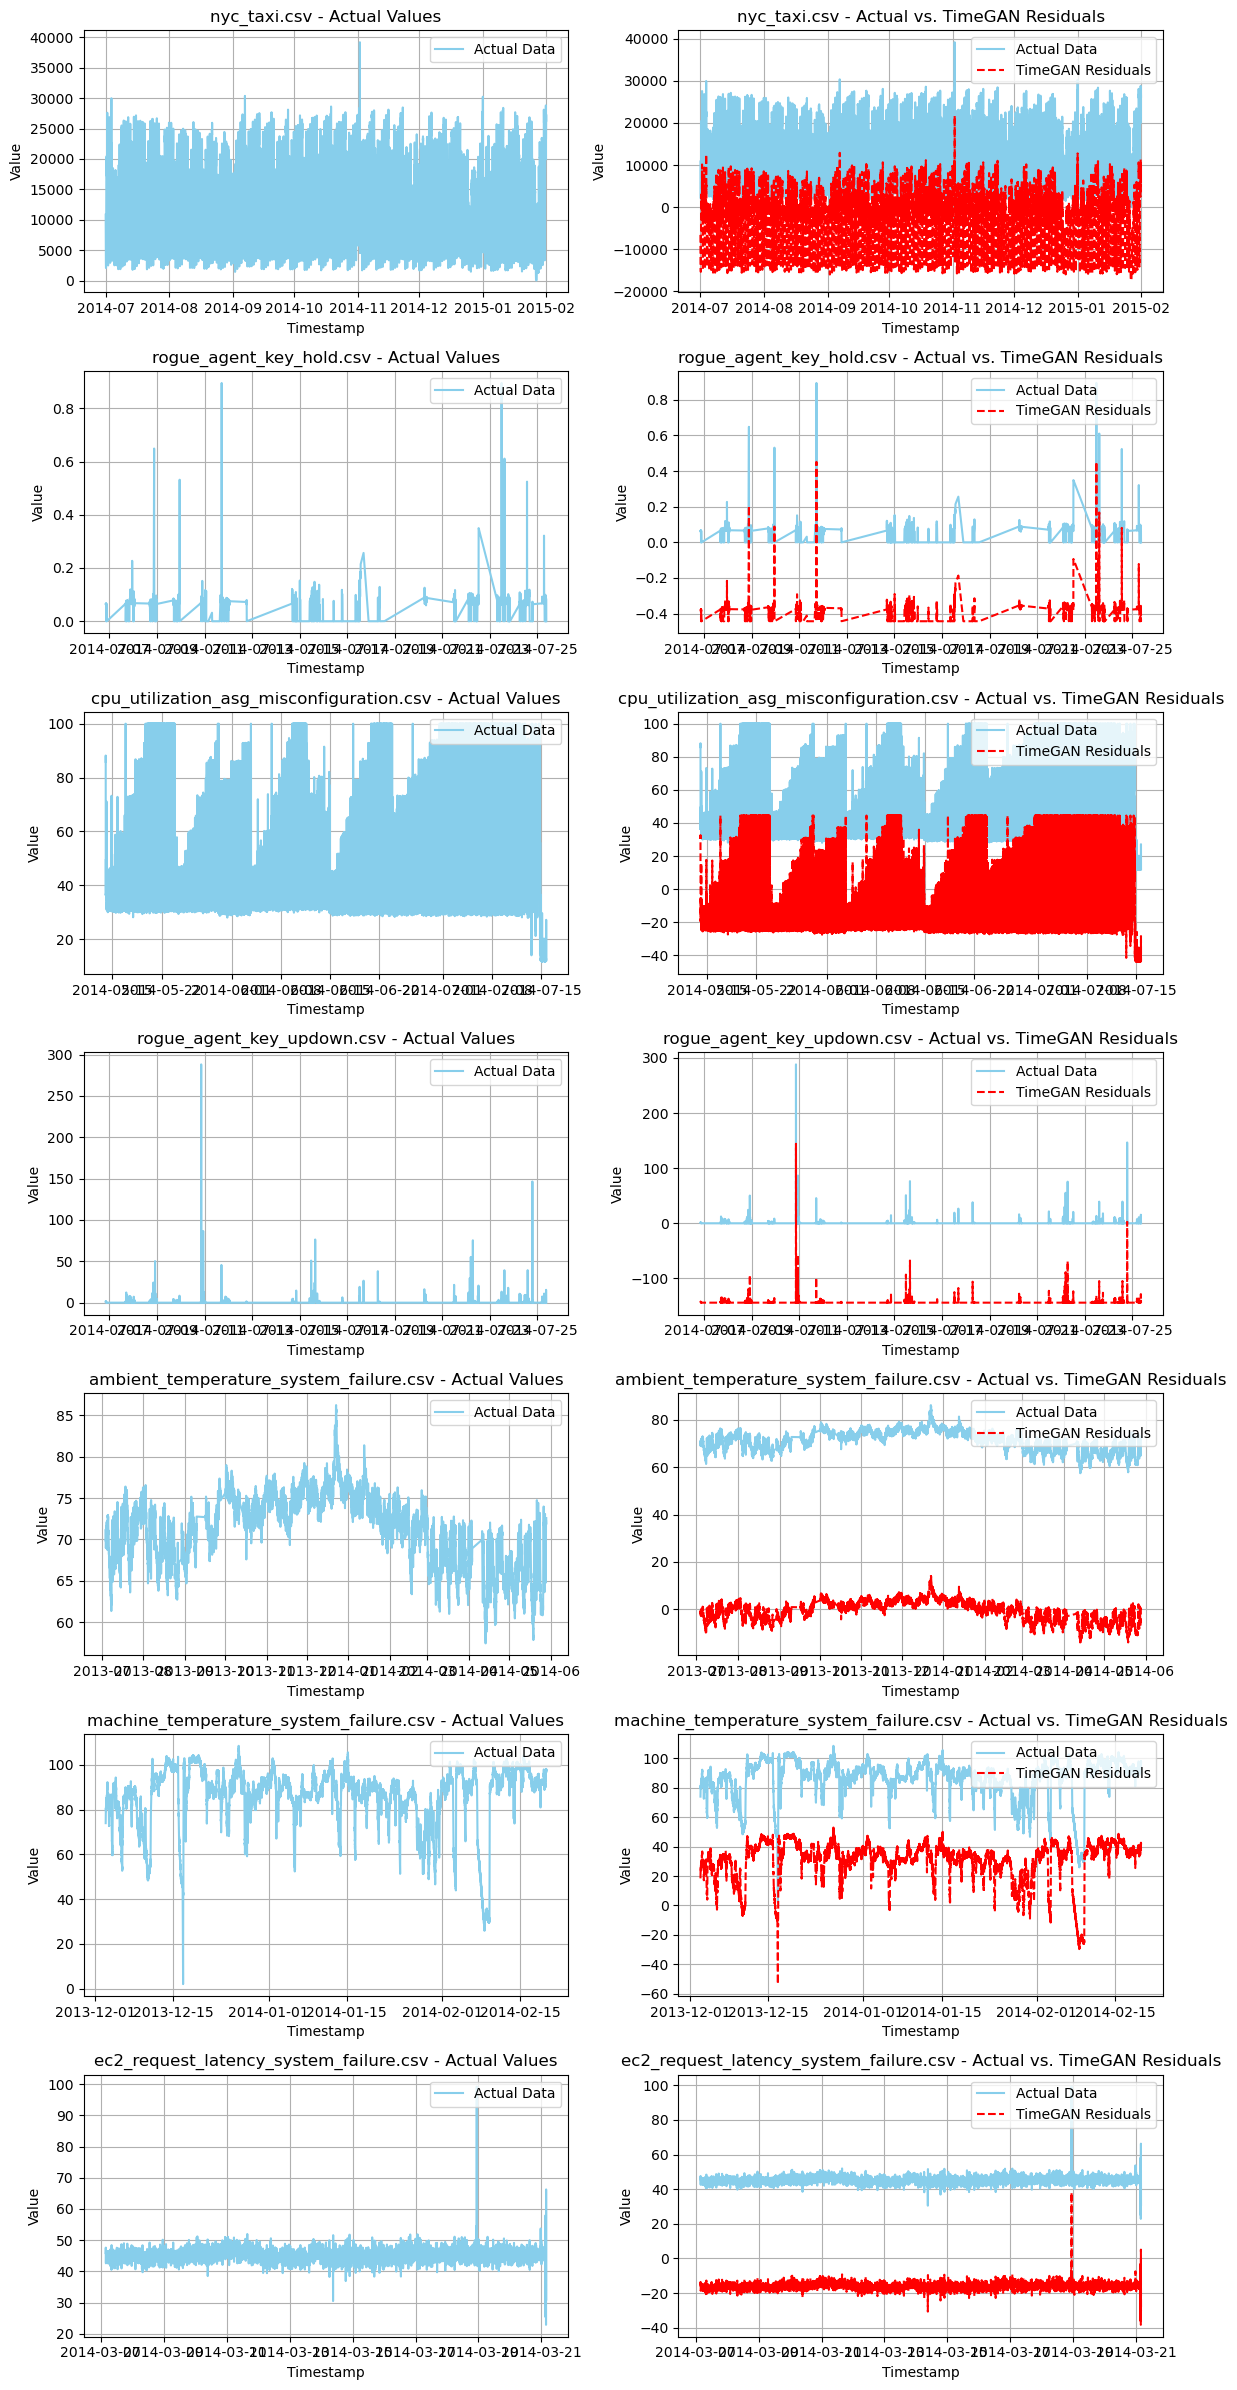

In [8]:
def plot_residuals(df, base_col, resid, title, ax, model): 
    
    # Left plot: Only "value" column
    ax[0].plot(df['timestamp'], df[base_col], label="Actual Data", color='skyblue')
    ax[0].set_xlabel("Timestamp")
    ax[0].set_ylabel("Value")
    ax[0].legend(loc='upper right')
    ax[0].set_title(f"{title} - Actual Values")
    ax[0].grid(True)
    
    # Right plot: "value" column and ARIMA residuals
    ax[1].plot(df['timestamp'], df[base_col], label="Actual Data", color='skyblue')
    ax[1].plot(df['timestamp'], df[resid], label=f"{model} Residuals", color='red', linestyle='dashed')
    ax[1].set_xlabel("Timestamp")
    ax[1].set_ylabel("Value")
    ax[1].set_title(f"{title} - Actual vs. {model} Residuals")
    ax[1].legend(loc='upper right')
    ax[1].grid(True)
    


fig, axes = plt.subplots(len(results), 2, figsize=(12, 24))  # Create a 2x1 grid of subplots
i = 0


for filename, result_df in zip(file_names, results):
    filename = filename.split('/')[1]
    plot_residuals(result_df, 'value', 'residual', filename, axes[i], 'TimeGAN')
    i += 1
    
# Show plot
plt.tight_layout()
#plt.savefig('timegan_resid_allfiles.png')
plt.show()

# ECOD

nyc_taxi.csv 5 1032 3 1029
rogue_agent_key_hold.csv 2 534 0 534
cpu_utilization_asg_misconfiguration.csv 2 1804 1 1803
rogue_agent_key_updown.csv 2 534 0 534
ambient_temperature_system_failure.csv 2 788 2 786
machine_temperature_system_failure.csv 4 2268 4 2264
ec2_request_latency_system_failure.csv 3 404 3 401


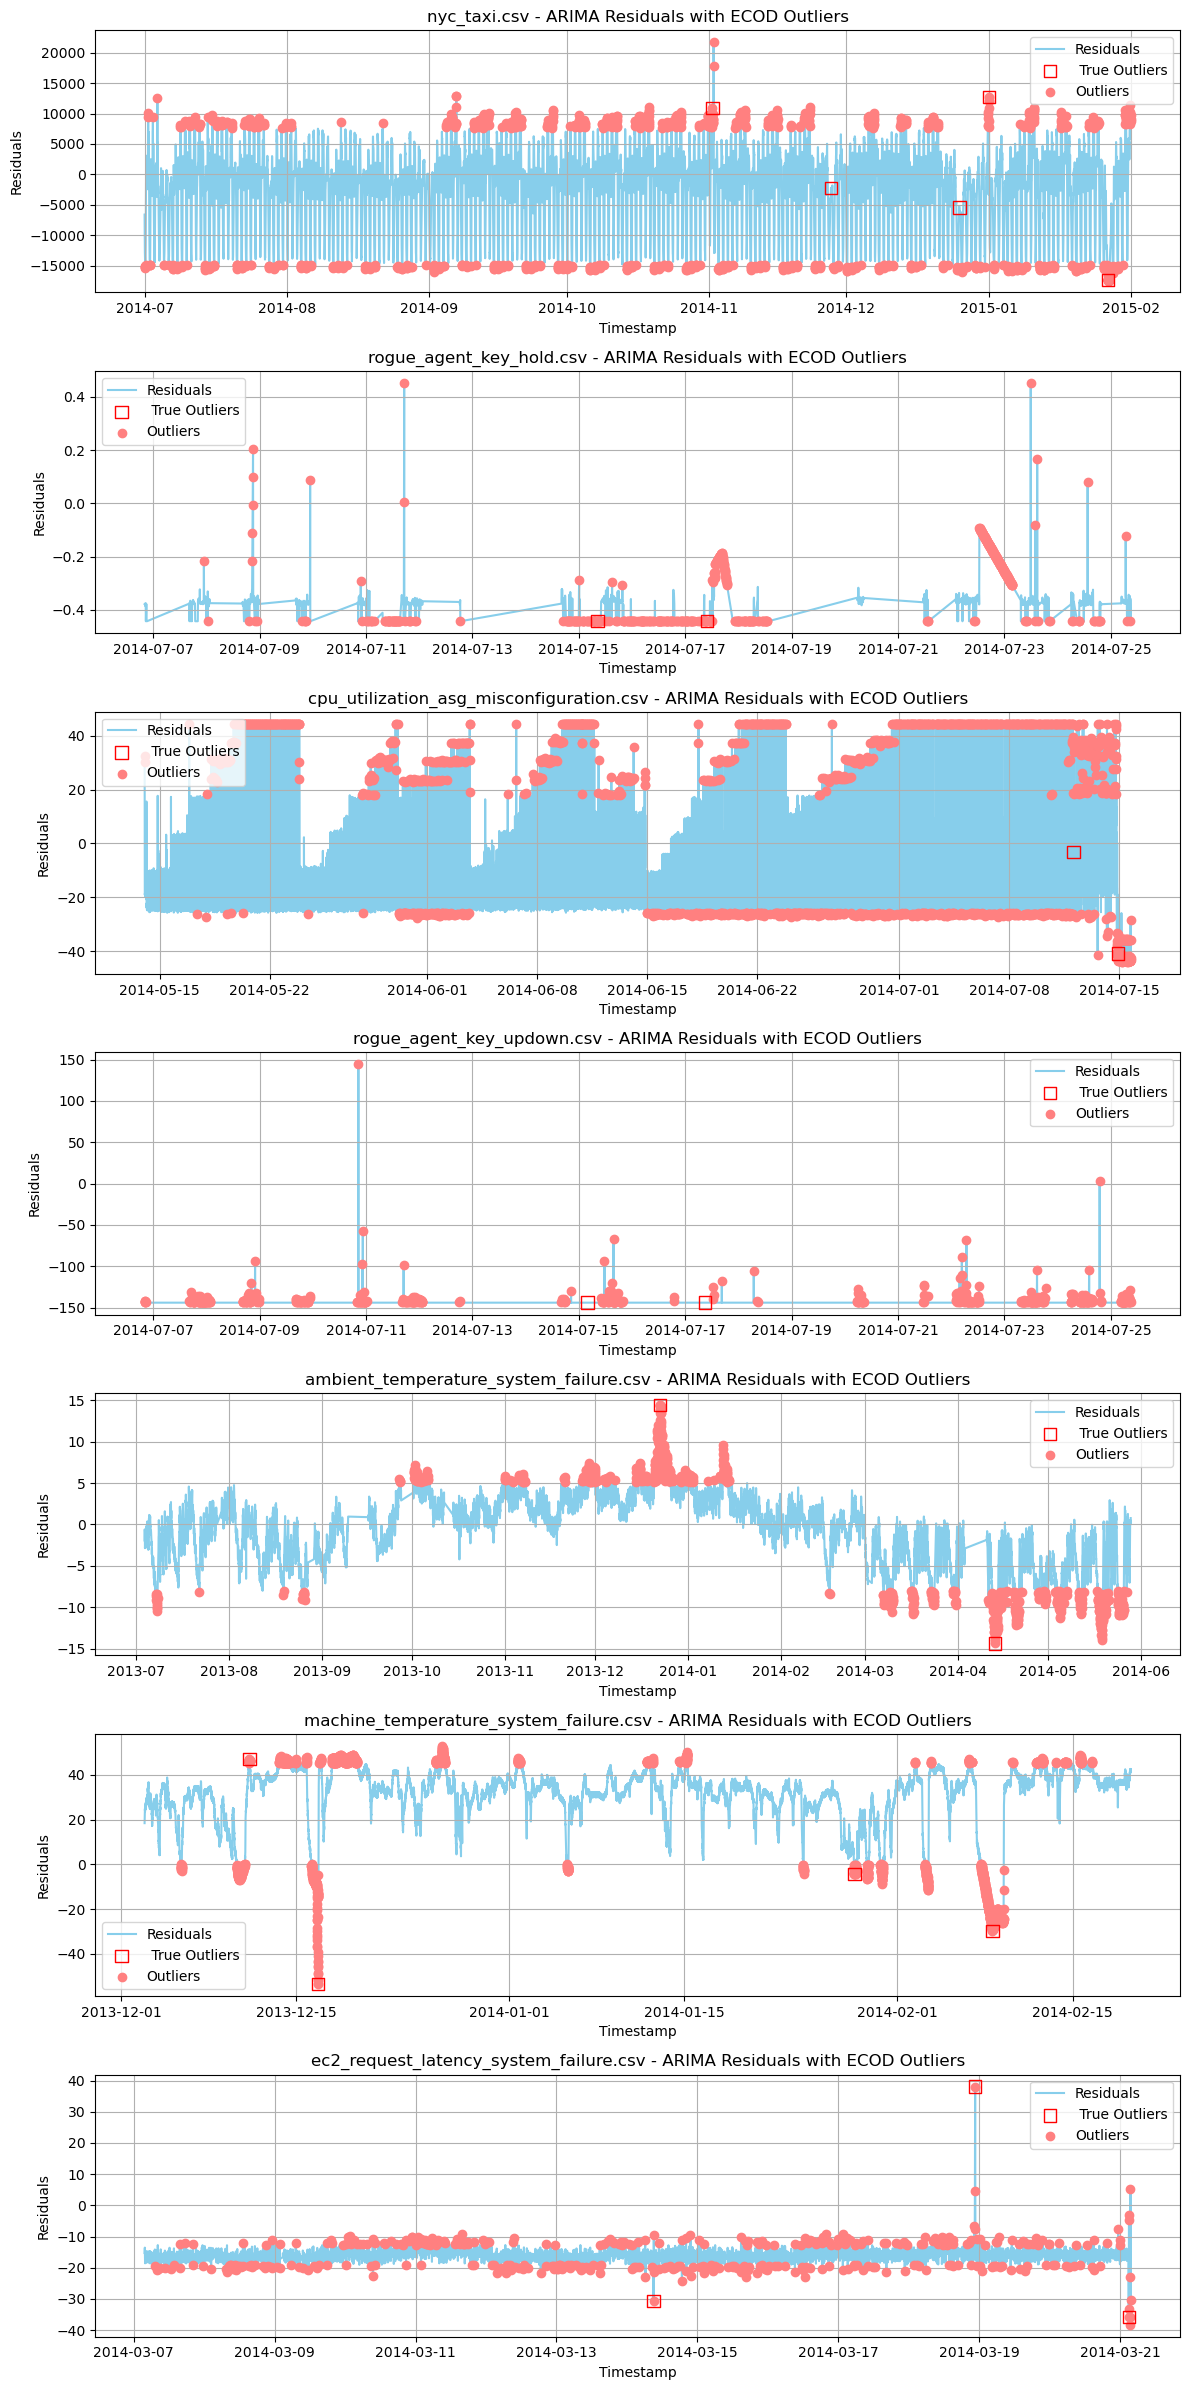

In [9]:
from pyod.models.ecod import ECOD

def plot_residuals_with_ecod_outliers(df, timestamp_col, residual_col, title, ax):
    
    feature = df[[residual_col]]
    ecod = ECOD()
    ecod.fit(feature)
    df['ecod_label'] = ecod.labels_

    ax.plot(df[timestamp_col], df[residual_col], label='Residuals', color='skyblue', zorder=1)
    ax.scatter(df[timestamp_col][df['outlier'] == 1], df[residual_col][df['outlier'] == 1], color='none', edgecolor='red', label=' True Outliers', marker='s', s=80, zorder=3)
    ax.scatter(df[timestamp_col][df['ecod_label'] == 1], df[residual_col][df['ecod_label'] == 1], color='#FF8080', label='Outliers', zorder=2)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{title} - ARIMA Residuals with ECOD Outliers')
    ax.legend()
    ax.grid(True)

    total_anomalies = len(df[residual_col][df['outlier'] == 1])
    total_predicted = len(df[residual_col][df['ecod_label'] == 1])
    total_true_predicted = len(df[ (df['ecod_label'] == 1) & (df['outlier'] == 1)] )
    total_mis_label = len(df[(df['ecod_label'] == 1) & (df['outlier'] == 0)])
    
    print(title, total_anomalies, total_predicted, total_true_predicted, total_mis_label)
    
fig, axes = plt.subplots(len(results), 1, figsize=(12, 24))  # Create a 2x1 grid of subplots
i = 0


for filename, result_df in zip(file_names, results):
    filename = filename.split('/')[1]
    plot_residuals_with_ecod_outliers(result_df, 'timestamp', 'residual', filename, axes[i])
    i += 1
    
# Show plot
plt.tight_layout()
#plt.savefig('timegan_ecod_allfiles.png')
plt.show()


# In data chunks

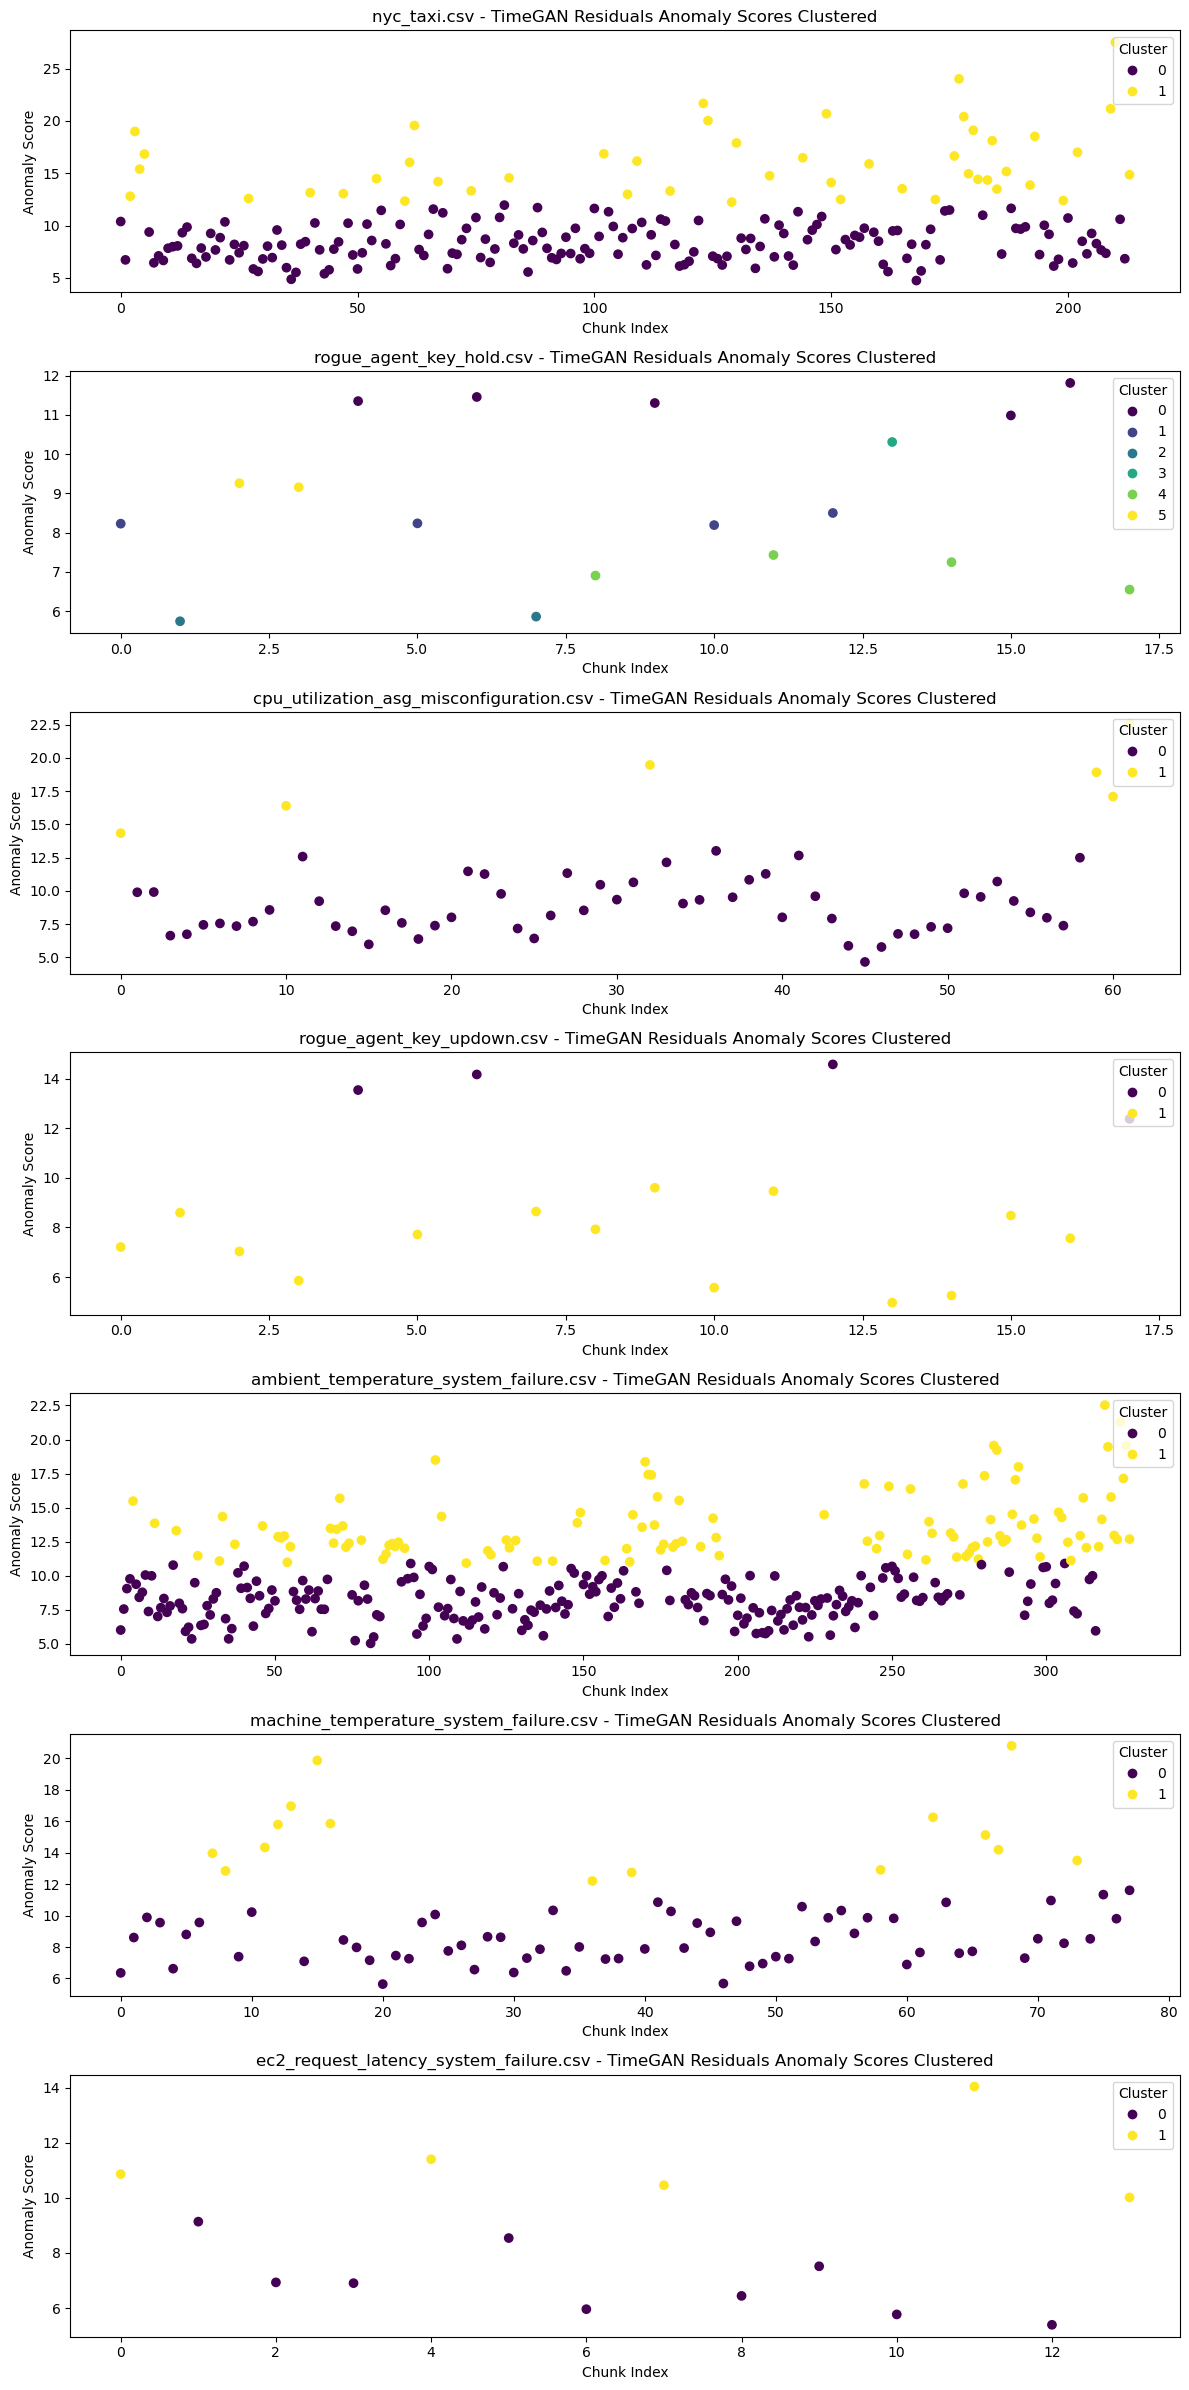

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import skew, kurtosis

def compute_chunk_features(chunk):
    # Calculate robust statistical features
    mean = np.mean(chunk)
    std_dev = np.std(chunk)
    skewness = skew(chunk)
    kurt = kurtosis(chunk)
    range_val = np.max(chunk) - np.min(chunk)
    median = np.median(chunk)

    # Ensure values are scalars
    return {
        'mean': float(mean),
        'std_dev': float(std_dev),
        'skewness': float(skewness.item()),
        'kurtosis': float(kurt.item()),
        'range': float(range_val),
        'median': float(median)
    }


def chunk_anomaly_scores(df, value_col, chunk_size=288):
    values = df[[value_col]].values
    chunks = [values[i:i + chunk_size] for i in range(0, len(values) - chunk_size, chunk_size)]

    # Compute features for each chunk
    chunk_features = [compute_chunk_features(chunk) for chunk in chunks]

    # Convert chunk features to a numpy array for ECOD input
    features_matrix = np.array([[chunk['mean'], chunk['std_dev'], chunk['skewness'], chunk['kurtosis'],
                                 chunk['range'], chunk['median']] for chunk in chunk_features])

    # Initialize ECOD model
    ecod = ECOD()

    # Fit ECOD model on the chunk features
    ecod.fit(features_matrix)

    # Get anomaly scores for each chunk
    anomaly_scores = ecod.decision_function(features_matrix)
    
    return anomaly_scores


def optimal_cluster(anomaly_scores):
    
    anomaly_scores = anomaly_scores.reshape(-1, 1)
    k_values = range(2, 11)
    silhouette_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(anomaly_scores)
        score = silhouette_score(anomaly_scores, kmeans.labels_)
        silhouette_scores.append(score)
    best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
    
    return best_k

def apply_kmeans(anomaly_scores, best_k, title, ax, model):
    anomaly_scores = anomaly_scores.reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=best_k, random_state=42)  # Example with 2 clusters
    kmeans.fit(anomaly_scores)

    cluster_labels = kmeans.labels_

    # Visualize the clustering result (optional)
    # ax.scatter(range(len(anomaly_scores)), anomaly_scores, c=cluster_labels)
    scatter = ax.scatter(range(len(anomaly_scores)), anomaly_scores, c=cluster_labels)

    ax.set_title(f"{title} - {model} Residuals Anomaly Scores Clustered")
    ax.set_xlabel("Chunk Index")
    ax.set_ylabel("Anomaly Score")

    # Add a legend
    handles, labels = scatter.legend_elements()
    ax.legend(handles, labels, title="Cluster", loc='upper right')

    return cluster_labels



fig, axes = plt.subplots(len(results), 1, figsize=(12, 24))  # Create a 2x1 grid of subplots
i = 0
candidate = 0

all_cluster_labels = list() 
for window_size, result_df, filename in zip(window_sizes, results, file_names):
    filename = filename.split('/')[1]
    chunk = window_size['daily']
    anomaly_scores = chunk_anomaly_scores(result_df, 'residual', chunk)
    best_k = optimal_cluster(anomaly_scores)
    if best_k == 2:
        candidate += 1
    cluster_labels = apply_kmeans(anomaly_scores, best_k, filename, axes[i], 'TimeGAN')
    all_cluster_labels.append(cluster_labels)
    i += 1


# Show plot
plt.tight_layout()
plt.savefig('timegan_chunks_clusterd_allfiles.png')
plt.show()

nyc_taxi.csv 5 47 5 42
cpu_utilization_asg_misconfiguration.csv 2 6 2 4
rogue_agent_key_updown.csv 2 14 2 12
ambient_temperature_system_failure.csv 2 113 2 111
machine_temperature_system_failure.csv 4 15 3 12
ec2_request_latency_system_failure.csv 3 5 3 2


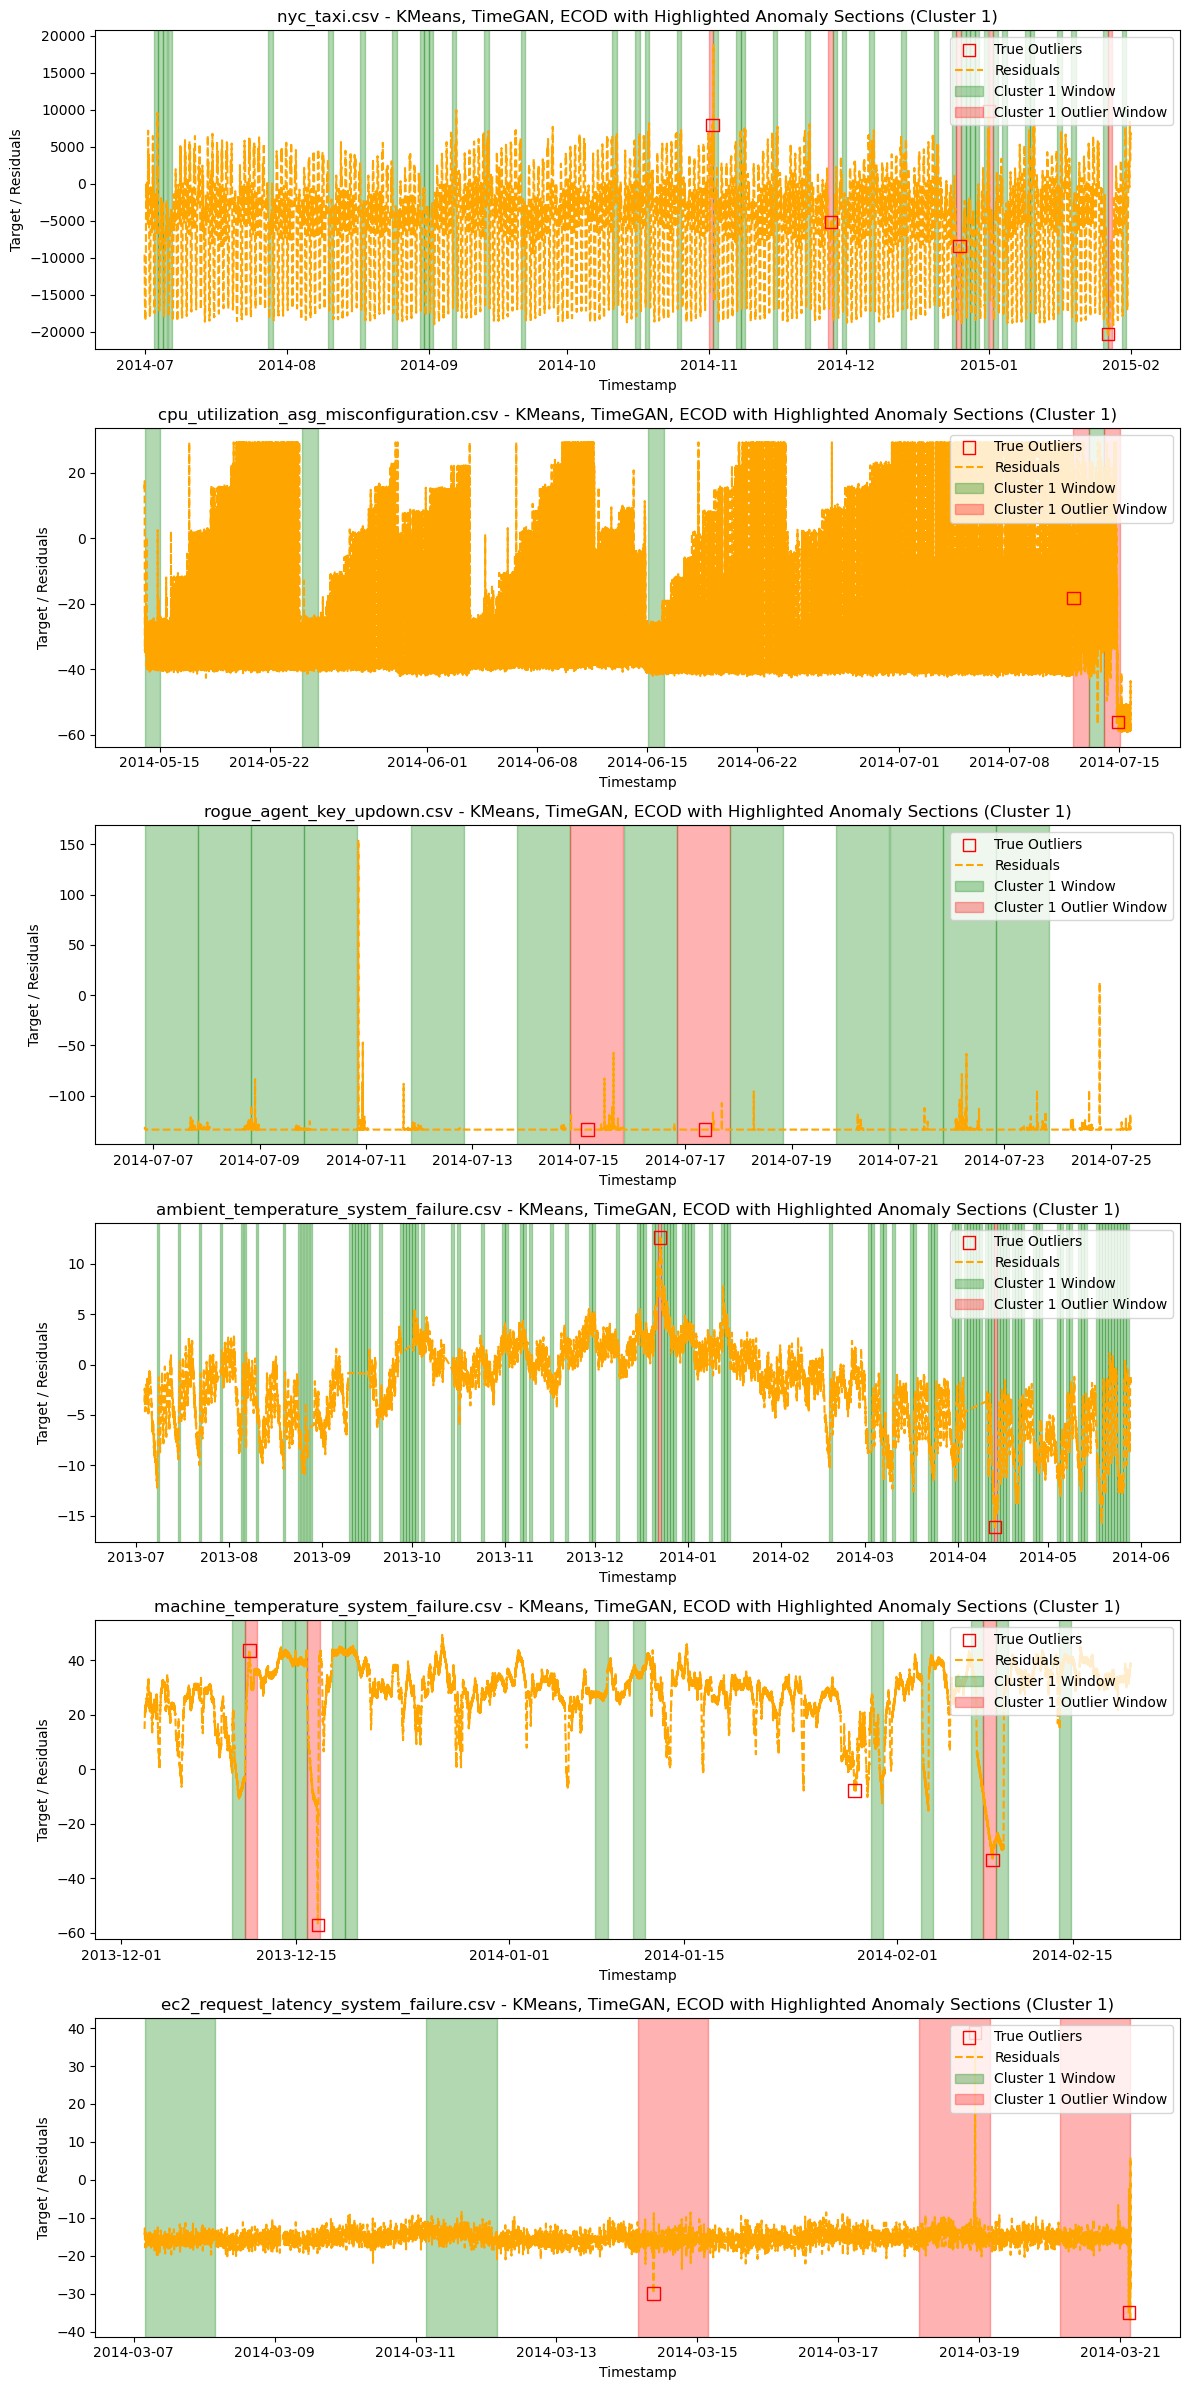

In [32]:
def plot_for_2_cluster(df, cluster_labels, base_col, resid, title, chunk, ax, model):
    # Plot the original data
    ax.scatter(df['timestamp'][df['outlier'] == 1], df[resid][df['outlier'] == 1], color='none', edgecolor='red', label='True Outliers', marker='s', s=80, zorder=3)
    ax.plot(df['timestamp'], df[resid], label='Residuals', color='orange', linestyle='dashed')

    count_labels, count_true_labels, count_mis_labels = 0, 0, 0
    outlier_label_added = False  # Track if the outlier label has been added
    cluster_label_added = False # Track if the cluster label has been added

    # Loop over the chunks and color the background where cluster label is 1
    for chunk_idx in range(len(cluster_labels)):
        if cluster_labels[chunk_idx] == 1:
            # Define the start and end index of the chunk in terms of dfcopy
            chunk_start = chunk_idx * chunk
            chunk_end = chunk_start + chunk

            # Ensure we do not exceed the length of dfcopy
            if chunk_end > len(df):
                chunk_end = len(df)

            count_labels += 1

            # Color the background of this chunk (use axvspan for background coloring)
            if (df['outlier'].iloc[chunk_start:chunk_end] == 1).any():  # Check if any true outlier in the chunk
                label = 'Cluster 1 Outlier Window' if not outlier_label_added else "" # Add label only once
                ax.axvspan(df['timestamp'].iloc[chunk_start], df['timestamp'].iloc[chunk_end - 1],
                           color='red', alpha=0.3, label=label)
                outlier_label_added = True
                count_true_labels += 1
                
            else:
                label = 'Cluster 1 Window' if not cluster_label_added else ""
                ax.axvspan(df['timestamp'].iloc[chunk_start], df['timestamp'].iloc[chunk_end - 1],
                           color='green', alpha=0.3, label=label)
                cluster_label_added = True
                count_mis_labels += 1

    number_outlier = len(df[resid][df['outlier'] == 1])
    print(title, number_outlier, count_labels, count_true_labels, count_mis_labels)

    # Customize the plot
    ax.set_title(f"{title} - KMeans, {model}, ECOD with Highlighted Anomaly Sections (Cluster 1)")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Target / Residuals")
    ax.legend(loc='upper right')


fig, axes = plt.subplots(candidate, 1, figsize=(12, 24))  # Create a 2x1 grid of subplots
i = 0

for window_size, result_df, filename, cluster_labels in zip(window_sizes, results, file_names, all_cluster_labels):
    total_cluster = len(np.unique(cluster_labels))
    if total_cluster != 2: 
        continue 
        
    filename = filename.split('/')[1]
    chunk = window_size['daily']
    plot_for_2_cluster(result_df, cluster_labels, 'value', 'residual', filename, chunk, axes[i], 'TimeGAN')
    i += 1


# Show plot
plt.tight_layout()

plt.savefig('timegan_chunk_results.png')
plt.show()
